In [1]:
import os
import glob
import time
import random
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

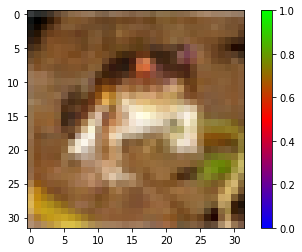

In [7]:
plt.imshow((train_x[0]/2+0.5).reshape(32, 32, 3), cmap='brg')
plt.colorbar()
plt.show()

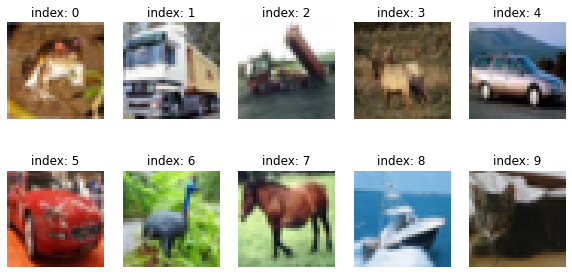

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]/2+0.5).reshape(32, 32, 3), cmap='brg')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

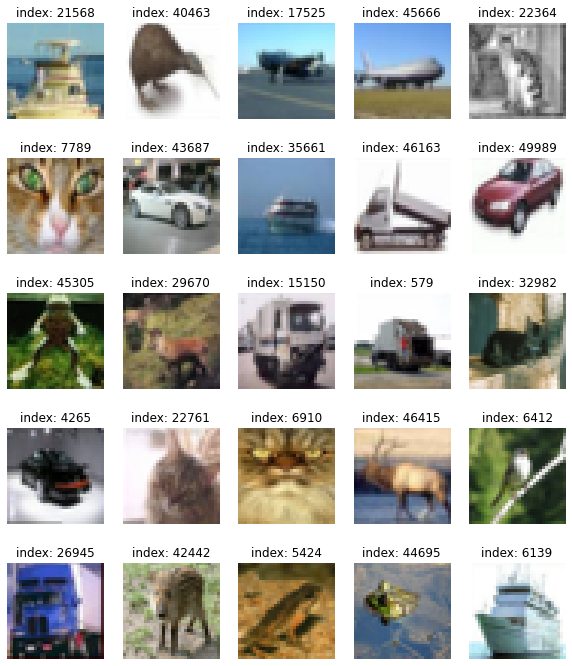

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(0, len(train_x))
    plt.imshow((train_x[random_index]/2+0.5).reshape(32, 32, 3), cmap='brg')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       5

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

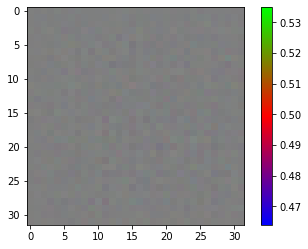

In [16]:
plt.imshow(generated_image[0, :, :, :]/2+0.5, cmap='brg')
plt.colorbar()
plt.show()

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)        

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00175878]], dtype=float32)>

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output)*random.uniform(0.9, 1.0), fake_output)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*random.uniform(0.9, 1.0), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [24]:
# import tensorflow_addons as tfa
# step = tf.Variable(0, trainable=False)
# schedule = tf.optimizers.schedules.PiecewiseConstantDecay([5000, 20000], [1e-0, 1e-1, 1e-2])
# # lr and wd can be a function or a tensor
# lr = 1e-3 * schedule(step)
# wd = 1e-4 * schedule(step)

# generator_optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd, beta_1=0.5)
# discriminator_optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd, beta_1=0.5)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.5)

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images+(tf.random.normal(images.shape)/255), training=True)
        fake_output = discriminator(generated_images+(tf.random.normal(generated_images.shape)/255), training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :]/2+0.5, cmap='brg')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_2/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'],alpha = 0.5)  
    plt.plot(history['disc_loss'],alpha = 0.5)  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'],alpha = 0.5)  
    plt.plot(history['real_accuracy'],alpha = 0.5)  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_2/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    n=0
    for epoch in range(n,n+epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                print()

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

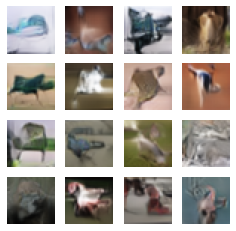

Time for training : 32846 sec


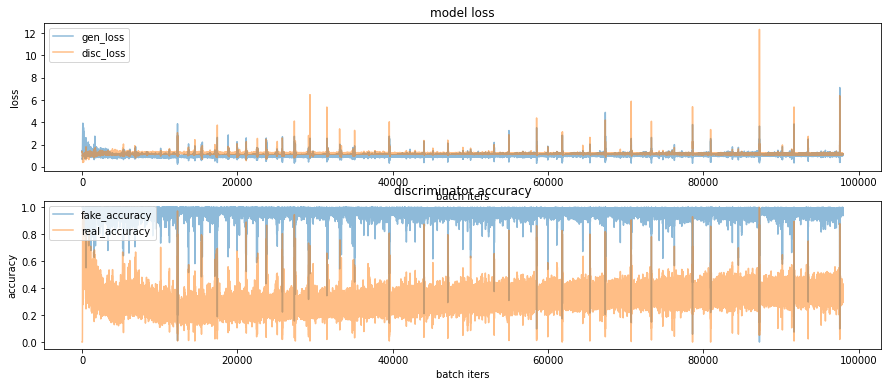

CPU times: user 6h 39min 45s, sys: 2h 27min 42s, total: 9h 7min 27s
Wall time: 9h 7min 30s


In [32]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_2/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1457972 Nov  9 06:54 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


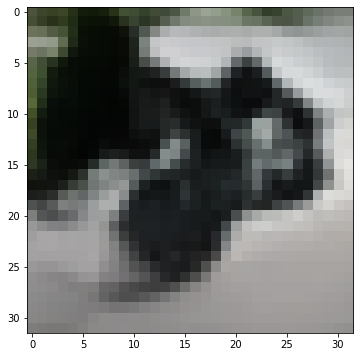

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

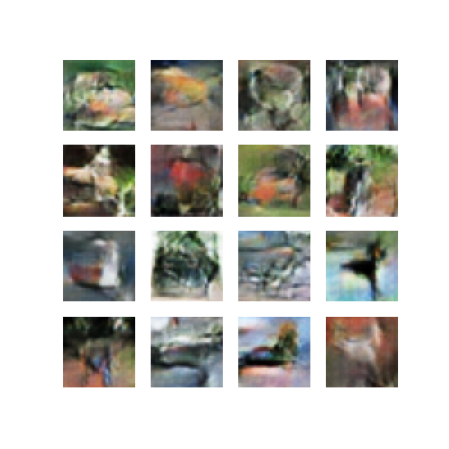

In [36]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_d/generated_samples/sample_epoch_0793_iter_151.png'
img=imageio.imread(path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

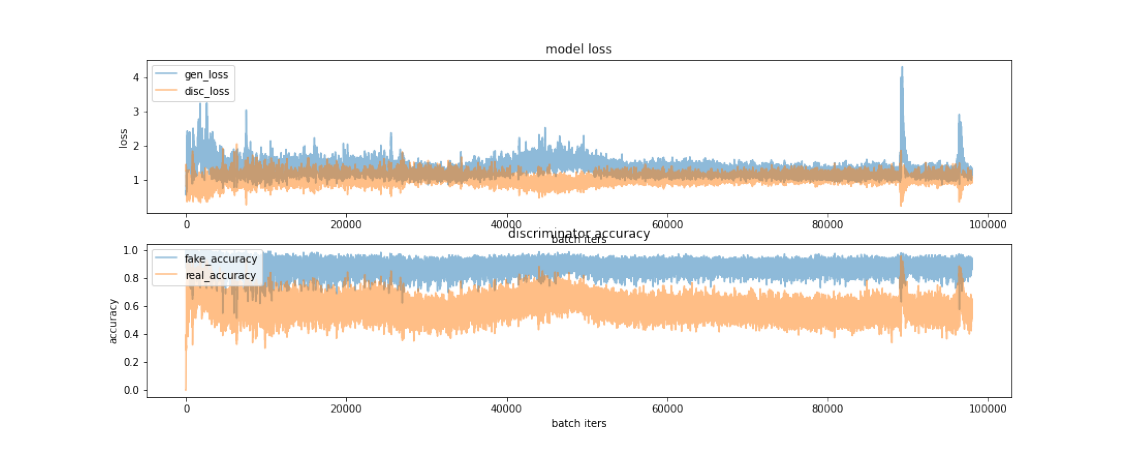

In [37]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_d/training_history/train_history_0499.png'
img=imageio.imread(path)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

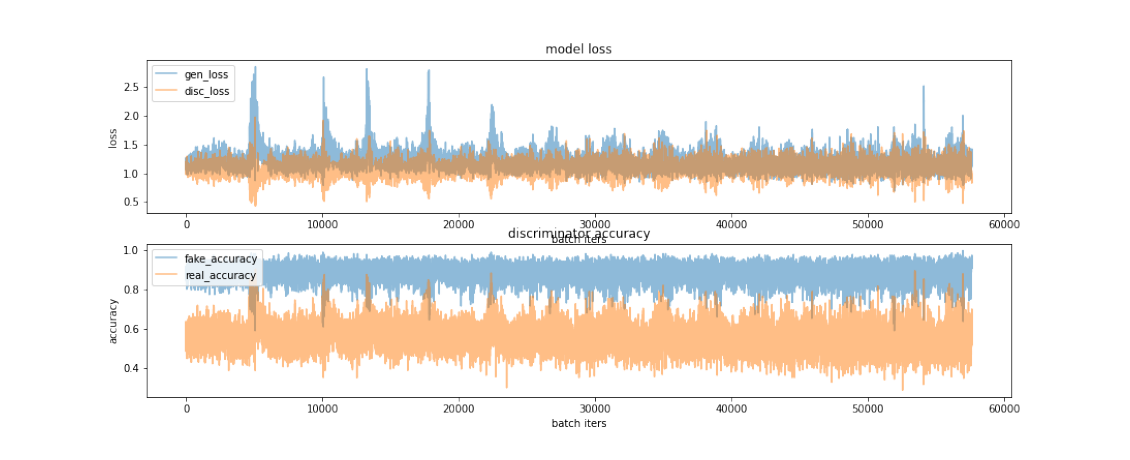

In [38]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_d/training_history/train_history_0793.png'
img=imageio.imread(path)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

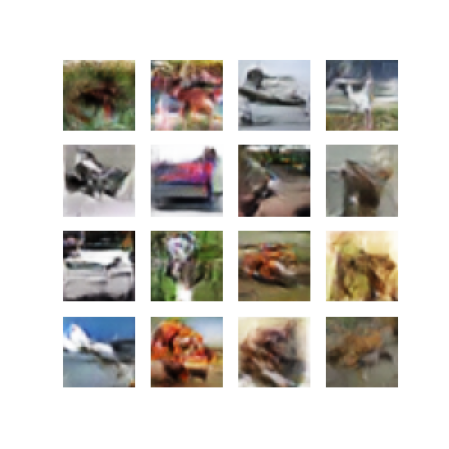

In [39]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0806_iter_151.png'
img=imageio.imread(path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

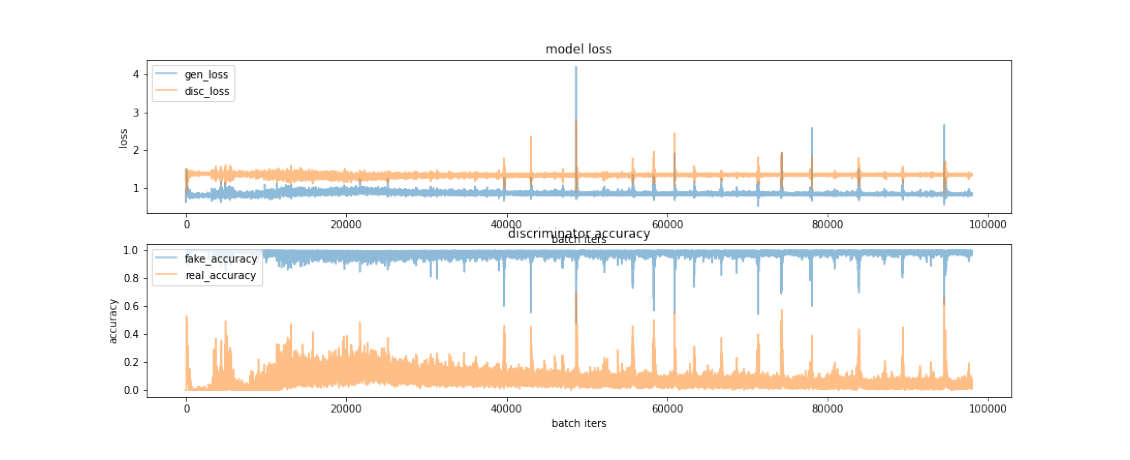

In [40]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_history/train_history_0499.png'
img=imageio.imread(path)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

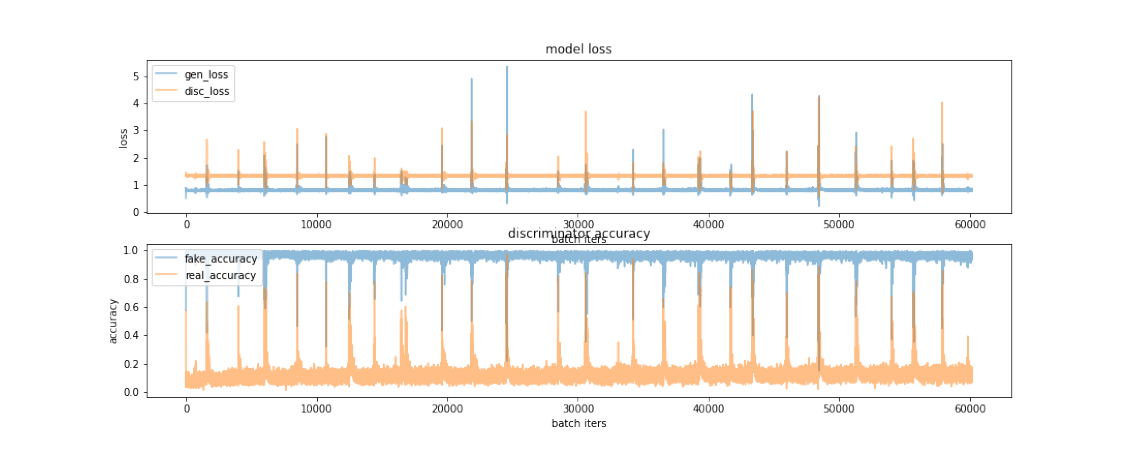

In [41]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_history/train_history_0806.png'
img=imageio.imread(path)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

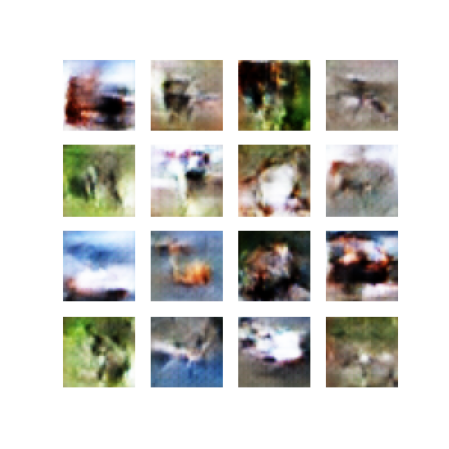

In [42]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2_sample_epoch_0757_iter_151.png'
img=imageio.imread(path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

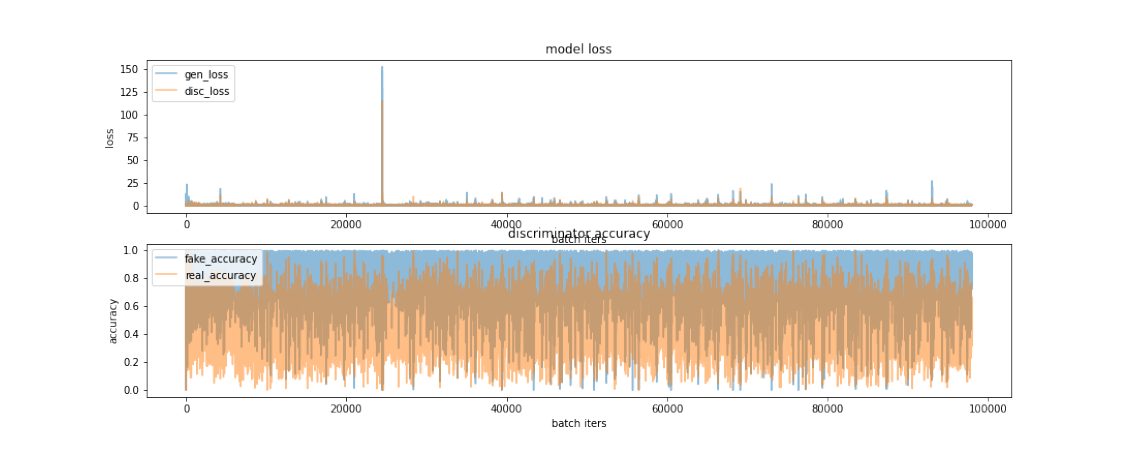

In [43]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2_train_history_0499.png'
img=imageio.imread(path)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

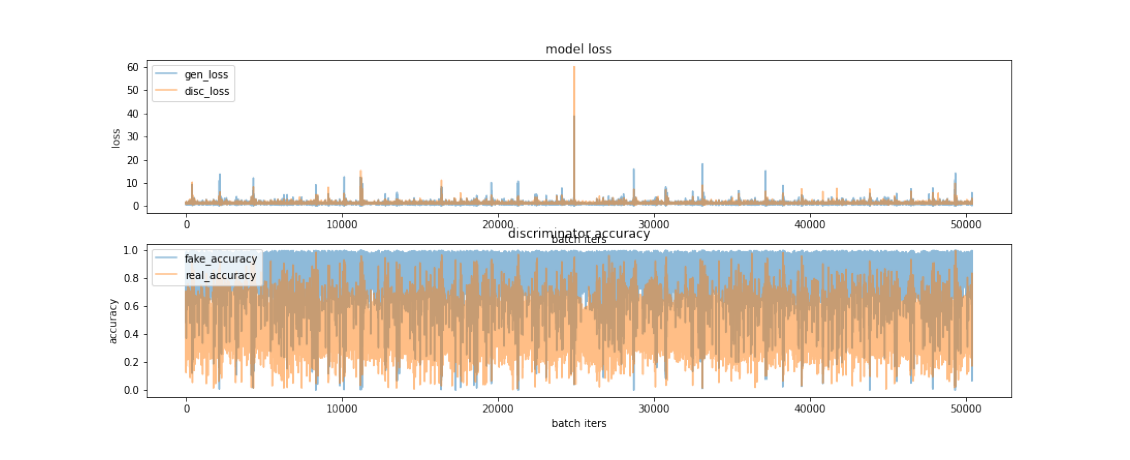

In [44]:
path=os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2_train_history_0756.png'
img=imageio.imread(path)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

여러 요소를 바꾸어 보며 결과 이미지와 그래프를 보았을 때 느낀점
generator Model 변경
- BatchNormalization 제거할 경우 이미지 생성이 원활하지 않음
- SpectralNormalization을 BatchNormalization 대신 넣어봤는데 결과 향상에 도움되지 않음
- Dropout 넣었을때와 안넣었을때 큰 차이를 보이지 않았다.
- Virtual Batch Normalization는 코드 활용법을 몰라서 못해봄

AdamW optimizers, learning rate schedule 결과 향상에 도움되지 않음
Adding Noise, Label Smoothing 값에 따라 결과 그래프가 많이 변하기는 하는데 값을 바꿔도 fake accuracy가 추세적으로 0.5를 향해 하향하는 그래프를 볼 수는 없었다.
fake accuracy가 0.5까지 내려와도 1.0에서 0.5까지 변동폭이 크고 real accuracy도 변동폭이 상당히 크게 나타났다.